Implementation of Successive Line Overrelaxation algorithm used for solving two-dimensional heat equation.
$$\frac{\partial \phi}{\partial t} = \frac{\partial}{\partial x}(\lambda_{x}\frac{\partial \phi}{\partial x}) + \frac{\partial}{\partial y}(\lambda_{y}\frac{\partial \phi}{\partial y})$$


In [1]:
import numpy as np

In [22]:
class SLOR:
    def __init__(self, vx, vy, NX, NY, SizeX, SizeY, dt, t_max, w, eps=0.01):
        """
            vx, xy: lambda parameters of equation
            NX, NY: number of nodes of x y
            SizeX, SizeY: size of grid
            dt : time-step
            w: relaxation parameter
            t_max: maximum time
            eps: maximum convergence relative error
        """
        self.vx, self.vy = vx, vy
        self.NX, self.NY = NX, NY
        self.SizeX, self.SizeY = SizeX, SizeY
        self.dt = dt
        self.t_max = t_max
        self.eps = eps
        self.w = w
        
    def convert(self, i , j):
        """
            This function maps indexes (i,j) to coordinates (x_i, y_i)
            0 < i,j < self.NX, self.NY
        """
        return float(i) / self.NX, float(j) / self.NY
    
    def solve(self, start_phi, border_phi):
        """
            start_phi: starting conditions, function from two parameters
            border_phi: border conditions, function from three conditions
        """
        # Creating grid
        dx = self.SizeX / self.NX
        dy = self.SizeY / self.NY
        # Coefficients
        TX = self.vx / dx ** 2
        TY = self.vy / dy ** 2
        
        b = np.full((self.NX, self.NY), -TX, dtype=float)
        c = np.full((self.NX, self.NY), -TX, dtype=float)
        f = np.full((self.NX, self.NY), -TY, dtype=float)
        g = np.full((self.NX, self.NY), -TY, dtype=float)
        d = np.zeros((self.NX, self.NY))
        gamma = 1. / self.dt
        a = -(c + b + g + f) + gamma
        diag = np.zeros((self.NX, self.NY))
        for i in xrange(self.NX):
            for j in xrange(self.NY):
                d[i][j] = gamma * start_phi(*self.convert(i, j))
                diag[i][j] = np.abs(a[i][j]) - np.abs(c[i][j])- np.abs(b[i][j]) - np.abs(f[i][j]) - np.abs(g[i][j])
        print np.min(diag)
        
        # Starting multilinear Gauss-Seidel method
        num_steps = int(self.t_max / self.dt)
        phi_gs = np.zeros((num_steps + 1, self.NX, self.NY)) # Result from Gauss-Seidel
        phi = np.zeros((num_steps + 1, self.NX, self.NY)) # Final result
        # Set start_conditions
        for i in xrange(self.NX):
            for j in xrange(self.NY):
                phi[0][i][j] = start_phi(*self.convert(i, j))
                phi_gs[0][i][j] = start_phi(*self.convert(i, j))
        stopped_step = 0
        for step in xrange(1, num_steps + 1):
            for i in xrange(self.NX):
                for j in xrange(self.NY):
                    d[i][j] = gamma * phi[step - 1][i][j]
            cur_time = step * self.dt
            # Set border_conditions
            for i in xrange(self.NX):
                phi_gs[step][i][0] = border_phi(*(self.convert(i, 0) + (cur_time,)))
                phi[step][i][0] = border_phi(*(self.convert(i, 0) + (cur_time,)))
                phi_gs[step][i][self.NY - 1] = border_phi(*(self.convert(i, self.NY - 1) + (cur_time,)))
                phi[step][i][self.NY - 1] = border_phi(*(self.convert(i, self.NY - 1) + (cur_time,)))
            for j in xrange(1, self.NY - 1):
                phi_gs[step][0][j] = border_phi(*(self.convert(0, j) + (cur_time,)))
                phi[step][0][j] = border_phi(*(self.convert(0, j) + (cur_time,)))
                phi_gs[step][self.NX - 1][j] = border_phi(*(self.convert(self.NX - 1, j) + (cur_time,)))
                phi[step][self.NX - 1][j] = border_phi(*(self.convert(self.NX - 1, j) + (cur_time,)))
            # Up
            # Thomas algorithm
            # p,q - auxillary variables
            # r - result vector in matrix equation: d[i][j] - g[i][j]*phi[step][i][j-1] - f[i][j]*phi[step][i][j + 1]
            p = np.zeros(self.NX)
            q = np.zeros(self.NX)
            r = np.zeros(self.NX)
            for j in xrange(1, self.NY - 1):
                for i in xrange(1, self.NX):
                    r[i] = d[i][j] - g[i][j]*phi_gs[step][i][j - 1] - f[i][j]*phi[step - 1][i][j + 1]
                    p[i] = b[i][j] / a[i][j] if i == 0 else b[i][j] / (a[i][j] - c[i][j]*p[i - 1])
                    q[i] = r[i] / a[i][j] if i == 0 else (r[i] - c[i][j] * q[i - 1]) / (a[i][j] - c[i][j] * p[i - 1])
                # phi_gs[step][self.NX-1][j] = q[self.NX - 1]
                phi_gs[step][self.NX-2][j] = q[self.NX - 2] - p[self.NX - 2] * q[self.NX - 1]
                for i in xrange(self.NX-3, 0, -1):
                    phi_gs[step][i][j] = q[i] - p[i] * phi_gs[step][i + 1][j]
            p = np.zeros(self.NX)
            q = np.zeros(self.NX)
            r = np.zeros(self.NX)
            # Down
            for j in xrange(self.NY-2, 0, -1):
                for i in xrange(1, self.NX):
                    r[i] = d[i][j] - g[i][j]*phi_gs[step][i][j - 1] - f[i][j]*phi_gs[step][i][j + 1]
                    p[i] = b[i][j] / a[i][j] if i == 0 else b[i][j] / (a[i][j] - c[i][j]*p[i - 1])
                    q[i] = r[i] / a[i][j] if i == 0 else (r[i] - c[i][j] * q[i - 1]) / (a[i][j] - c[i][j] * p[i - 1])
                #phi_gs[step][self.NX-1][j] = q[self.NX - 1]
                phi_gs[step][self.NX-2][j] = q[self.NX - 2] - p[self.NX - 2] * q[self.NX - 1]
                for i in xrange(self.NX-3, 0, -1):
                    phi_gs[step][i][j] = q[i] - p[i] * phi_gs[step][i + 1][j]
                    
            p = np.zeros(self.NY)
            q = np.zeros(self.NY)
            r = np.zeros(self.NY)
            # Right
            for i in xrange(1, self.NX - 1):
                for j in xrange(1, self.NY):
                    r[j] = d[i][j] - c[i][j]*phi_gs[step][i - 1][j] - b[i][j]*phi_gs[step][i + 1][j]
                    p[j] = f[i][j] / a[i][j] if j == 0 else f[i][j] / (a[i][j] - g[i][j]*p[j - 1])
                    q[j] = r[j] / a[i][j] if j == 0 else (r[j] - g[i][j] * q[j - 1]) / (a[i][j] - g[i][j] * p[j - 1])
                #phi_gs[step][i][self.NY-1] = q[self.NY - 1]
                phi_gs[step][i][self.NY - 2] = q[self.NY - 2] - p[self.NY - 2] * q[self.NY - 1]
                for j in xrange(self.NY - 3, 0, -1):
                    phi_gs[step][i][j] = q[j] - p[j] * phi_gs[step][i][j + 1]
            p = np.zeros(self.NY)
            q = np.zeros(self.NY)
            r = np.zeros(self.NY)
            # Left
            for i in xrange(self.NX-2, 0, -1):
                for j in xrange(1, self.NY):
                    r[j] = d[i][j] - c[i][j]*phi_gs[step][i][j] - b[i][j]*phi_gs[step][i + 1][j]
                    p[j] = f[i][j] / a[i][j] if j == 0 else f[i][j] / (a[i][j] - g[i][j]*p[j - 1])
                    q[j] = r[j] / a[i][j] if j == 0 else (r[j] - g[i][j] * q[j - 1]) / (a[i][j] - g[i][j] * p[j - 1])
                #phi_gs[step][i][self.NY-1] = q[self.NY - 1]
                phi_gs[step][i][self.NY - 2] = q[self.NY - 2] - p[self.NY - 2] * q[self.NY - 1]
                for j in xrange(self.NY - 3, 0, -1):
                    phi_gs[step][i][j] = q[j] - p[j] * phi_gs[step][i][j + 1]
            # Relaxation
            phi[step] = self.w * phi_gs[step] + (1. - self.w) * phi[step - 1]
            # Set border conditions again
            for i in xrange(self.NX):
                phi[step][i][0] = border_phi(*(self.convert(i, 0) + (cur_time,)))
                phi[step][i][self.NY - 1] = border_phi(*(self.convert(i, self.NY - 1) + (cur_time,)))
            for j in xrange(1, self.NY - 1):
                phi[step][0][j] = border_phi(*(self.convert(0, j) + (cur_time,)))
                phi[step][self.NX - 1][j] = border_phi(*(self.convert(self.NX - 1, j) + (cur_time,)))
            # Due to in array may be zero values, I add 1e-6 to denominator. You can delete, but you should use anoter norm
            error = np.max(np.abs(phi[step] - phi[step - 1]) / (np.abs(phi[step]) + 0.000001))
            if error < self.eps:
                print "Stopped at {0} iteration".format(step)
                stopped_step = step
                break
        if stopped_step == 0:
            stopped_step = num_steps
            print "Stopped at max iteration"
        return stopped_step, phi[stopped_step]

In [23]:
vx = vy = 1
input_dt = 0.01
slor = SLOR(vx, vy, NX=100, NY=100, SizeX=1., SizeY=1., dt=input_dt, t_max=1, w=0.1)
start_phi = lambda x,y: np.cos(np.pi * x) * np.sin(np.pi * y)
border_phi = lambda x,y,t: np.cos(np.pi * x) * np.sin(np.pi * y) * np.exp(-(vx + vy)*np.pi*np.pi*t)
stopped_step, result = slor.solve(start_phi, border_phi)

100.0
Stopped at max iteration


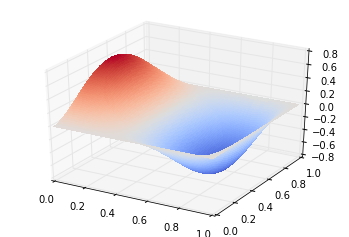

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import math

% matplotlib inline

# Our solution
fig = plt.figure()
ax = fig.gca(projection='3d')
x = y = np.arange(0., 1., 0.01)
xx, yy = np.meshgrid(x, y)
# I changed places of xx and yy just to find a better view
surf = ax.plot_surface(yy, xx, result, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

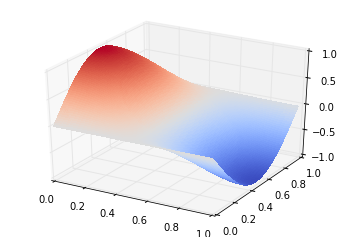

In [18]:
# Correct solution
fig = plt.figure()
ax = fig.gca(projection='3d')
x = y = np.arange(0, 1, 0.01)
xx, yy = np.meshgrid(x, y)
z = np.cos(np.pi * xx) * np.sin(np.pi * yy) * np.exp(-(vx + vy)*np.pi*np.pi*stopped_step * input_dt)
surf = ax.plot_surface(xx, yy, z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [33]:
A = np.zeros((10, 10))
d = np.ones(10)
for i in xrange(10):
    for j in xrange(10):
        if i - j == 1:
            A[i][j] = 1
        if i == j:
            A[i][j] = 2
        if i - j == -1:
            A[i][j] = 3

cc = np.zeros(10)
dd = np.zeros(10)
cc[0] = 3. / 2.
dd[0] = d[i] / 2.
for i in xrange(1, 10):
    cc[i] = 3. / (2. - cc[i-1])
    dd[i] = (d[i] - dd[i - 1]) / (2. - cc[i - 1])
x = np.zeros(10)
x[9] = dd[9]
for i in xrange(8, -1, -1):
    x[i] = dd[i] - cc[i] * x[i + 1]
np.dot(A, x)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [30]:
A

array([[ 2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.]])